In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [3]:
path = 'Potato_Dataset/'
train_dir = os.path.join(path, 'train')
valid_dir = os.path.join(path, 'valid')
test_dir = os.path.join(path, 'test')

# Get class names
dataset_path = [cls for cls in os.listdir(train_dir) if not cls.startswith('.')]
print("Classes:", dataset_path)
NUM_CLASSES = len(dataset_path)


Classes: ['lateblight', 'pest', 'healthy', 'fungi', 'virus', 'earlyblight']


In [5]:
dataset_dir = 'Potato_Dataset'
train_dir = os.path.join(dataset_dir, 'train')
valid_dir = os.path.join(dataset_dir, 'valid')
test_dir = os.path.join(dataset_dir, 'test')

folders_to_check = [train_dir, valid_dir, test_dir]
folder_to_remove = '.ipynb_checkpoints'

for folder in folders_to_check:
    checkpoint_path = os.path.join(folder, folder_to_remove)
    if os.path.exists(checkpoint_path) and os.path.isdir(checkpoint_path):
        try:
            shutil.rmtree(checkpoint_path)
            print(f"Removed '{folder_to_remove}' from: {folder}")
        except Exception as e:
            print(f"Error removing '{folder_to_remove}' from {folder}: {e}")
    else:
        print(f"'{folder_to_remove}' not found in: {folder}")

print("Removal process complete.")

# Image size and batch size
im_size = 224
BATCH_SIZE = 32
EPOCHS = 50  # Increased epochs, EarlyStopping will handle actual training duration

# Data Augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation and test sets
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create Data Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(im_size, im_size),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

validation_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=(im_size, im_size),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(im_size, im_size),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)
print("Train Generator Class Indices:", train_generator.class_indices)
print("Validation Generator Class Indices:", validation_generator.class_indices)
print("Test Generator Class Indices:", test_generator.class_indices)

'.ipynb_checkpoints' not found in: Potato_Dataset/train
'.ipynb_checkpoints' not found in: Potato_Dataset/valid
'.ipynb_checkpoints' not found in: Potato_Dataset/test
Removal process complete.
Found 4023 images belonging to 6 classes.
Found 862 images belonging to 6 classes.
Found 863 images belonging to 6 classes.
Train Generator Class Indices: {'earlyblight': 0, 'fungi': 1, 'healthy': 2, 'lateblight': 3, 'pest': 4, 'virus': 5}
Validation Generator Class Indices: {'earlyblight': 0, 'fungi': 1, 'healthy': 2, 'lateblight': 3, 'pest': 4, 'virus': 5}
Test Generator Class Indices: {'earlyblight': 0, 'fungi': 1, 'healthy': 2, 'lateblight': 3, 'pest': 4, 'virus': 5}


In [7]:
# Model setup with EfficientNetB0 and transfer learning
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(im_size, im_size, 3), pooling='avg')

# Fine-tuning: Unfreeze a portion of the base model
# --- Fine-tuning: Unfreeze an even smaller portion initially ---
base_model.trainable = True
for layer in base_model.layers[:-20]: # Try unfreezing only the last 10 layers
    layer.trainable = False

# --- Add custom top layers for classification ---
inputs = tf.keras.Input(shape=(im_size, im_size, 3))
x = base_model(inputs, training=False)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=inputs, outputs=output)

# --- Compile the model with a further reduced learning rate ---
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,715,689 (17.99 MB)

 Trainable params: 1,792,310 (6.84 MB)

 Non-trainable params: 2,923,379 (11.15 MB)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.1717 - loss: 2.3631
Epoch 1: val_accuracy improved from -inf to 0.18029, saving model to best_potato_model_efficientnetb0.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 63s 478ms/step - accuracy: 0.1718 - loss: 2.3627 - val_accuracy: 0.1803 - val_loss: 1.7974 - learning_rate: 5.0000e-05
Epoch 2/50
  1/125 ━━━━━━━━━━━━━━━━━━━━ 48s 393ms/step - accuracy: 0.0938 - loss: 2.5449

2025-04-10 06:16:44.686496: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 2: val_accuracy did not improve from 0.18029
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0938 - loss: 2.5449 - val_accuracy: 0.0000e+00 - val_loss: 2.0404 - learning_rate: 5.0000e-05
Epoch 3/50


2025-04-10 06:16:45.015514: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.1993 - loss: 2.2314
Epoch 3: val_accuracy did not improve from 0.18029
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 487ms/step - accuracy: 0.1992 - loss: 2.2316 - val_accuracy: 0.1803 - val_loss: 1.7893 - learning_rate: 5.0000e-05
Epoch 4/50
  1/125 ━━━━━━━━━━━━━━━━━━━━ 48s 390ms/step - accuracy: 0.1562 - loss: 2.4085
Epoch 4: val_accuracy did not improve from 0.18029
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1562 - loss: 2.4085 - val_accuracy: 0.0000e+00 - val_loss: 1.9659 - learning_rate: 5.0000e-05
Epoch 5/50


2025-04-10 06:17:46.859407: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.2030 - loss: 2.1934
Epoch 5: val_accuracy did not improve from 0.18029
125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 472ms/step - accuracy: 0.2029 - loss: 2.1936 - val_accuracy: 0.1346 - val_loss: 1.7907 - learning_rate: 5.0000e-05
Epoch 6/50
  1/125 ━━━━━━━━━━━━━━━━━━━━ 44s 355ms/step - accuracy: 0.0938 - loss: 2.4484
Epoch 6: val_accuracy did not improve from 0.18029
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0938 - loss: 2.4484 - val_accuracy: 0.0000e+00 - val_loss: 1.9789 - learning_rate: 5.0000e-05
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.1933 - loss: 2.1965
Epoch 7: val_accuracy did not improve from 0.18029
125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 468ms/step - accuracy: 0.1933 - loss: 2.1961 - val_accuracy: 0.1322 - val_loss: 1.7549 - learning_rate: 5.0000e-05
Epoch 8/50
  1/125 ━━━━━━━━━━━━━━━━━━━━ 46s 372ms/step - accuracy: 0.2812 - loss: 2.1859
Epoch 8: val_accuracy did not improve from 0.18029
125/125 

2025-04-10 06:19:46.300379: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.2022 - loss: 2.1639
Epoch 9: val_accuracy improved from 0.18029 to 0.25481, saving model to best_potato_model_efficientnetb0.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 467ms/step - accuracy: 0.2022 - loss: 2.1638 - val_accuracy: 0.2548 - val_loss: 1.7069 - learning_rate: 5.0000e-05
Epoch 10/50
  1/125 ━━━━━━━━━━━━━━━━━━━━ 45s 365ms/step - accuracy: 0.2812 - loss: 2.0982
Epoch 10: val_accuracy improved from 0.25481 to 0.96667, saving model to best_potato_model_efficientnetb0.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2812 - loss: 2.0982 - val_accuracy: 0.9667 - val_loss: 1.5351 - learning_rate: 5.0000e-05
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.1981 - loss: 2.1690
Epoch 11: val_accuracy did not improve from 0.96667
125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 471ms/step - accuracy: 0.1981 - loss: 2.1690 - val_accuracy: 0.1803 - val_loss: 1.7409 - learning_rate: 5.0000e-05
Epoch 12/50
  1/125 ━━━━━━━━

2025-04-10 06:23:47.183092: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.2355 - loss: 2.0649
Epoch 17: val_accuracy did not improve from 0.96667

Epoch 17: ReduceLROnPlateau reducing learning rate to 1.4999999621068127e-05.
125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 474ms/step - accuracy: 0.2354 - loss: 2.0650 - val_accuracy: 0.1779 - val_loss: 1.9188 - learning_rate: 5.0000e-05
Epoch 18/50
  1/125 ━━━━━━━━━━━━━━━━━━━━ 44s 361ms/step - accuracy: 0.2188 - loss: 2.0967
Epoch 18: val_accuracy did not improve from 0.96667
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2188 - loss: 2.0967 - val_accuracy: 0.0000e+00 - val_loss: 1.1906 - learning_rate: 1.5000e-05
Epoch 19/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.2303 - loss: 2.0026
Epoch 19: val_accuracy did not improve from 0.96667
125/125 ━━━━━━━━━━━━━━━━━━━━ 60s 476ms/step - accuracy: 0.2303 - loss: 2.0028 - val_accuracy: 0.1671 - val_loss: 1.7769 - learning_rate: 1.5000e-05
Epoch 20/50
  1/125 ━━━━━━━━━━━━━━━━━━━━ 46s 375ms/step - accura

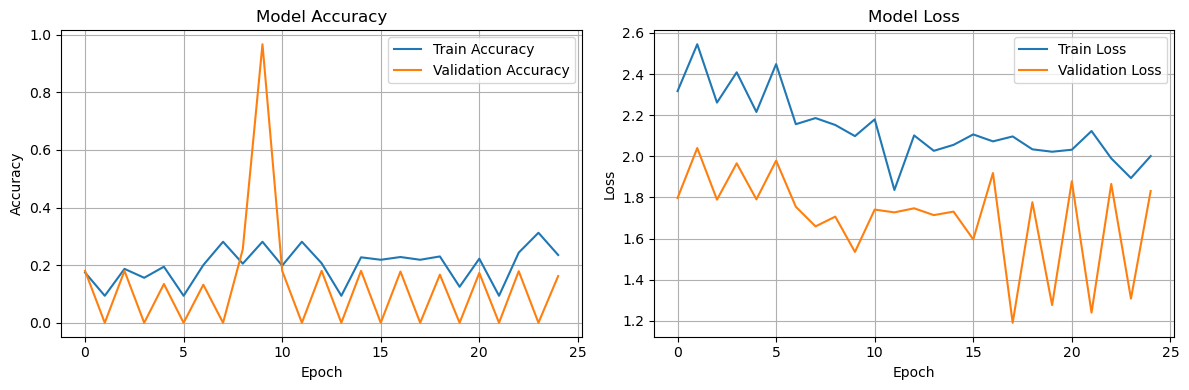

26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 341ms/step - accuracy: 0.1314 - loss: 1.7697
Test Loss: 1.7042, Test Accuracy: 0.2692
Training complete. The best model is saved as 'best_potato_model_efficientnetb0.keras'


In [9]:
# Define callbacks for better training
early_stop = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_potato_model_efficientnetb0.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=7, min_lr=1e-6, verbose=1)
callbacks = [early_stop, checkpoint, reduce_lr]

# --- Train the model ---
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

# Plot training history
def plot_hist(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_hist(history)

# Evaluate the model on the test set
best_model = tf.keras.models.load_model('best_potato_model_efficientnetb0.keras')
loss, accuracy = best_model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose=1)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

print("Training complete. The best model is saved as 'best_potato_model_efficientnetb0.keras'")

Class Names: ['earlyblight', 'fungi', 'healthy', 'lateblight', 'pest', 'virus']


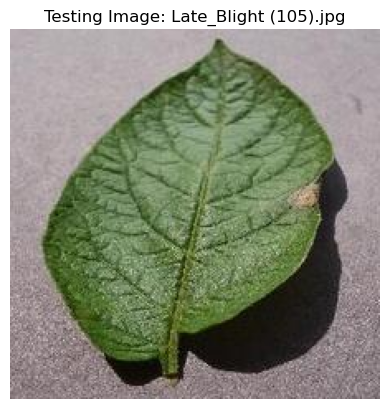

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
Prediction: virus (20.48%)


In [15]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt # Import matplotlib

# Load the best trained model
model = load_model('best_potato_model_efficientnetb0.keras')

# Assuming train_generator was defined in your training script
# If not, you'll need to load the class names explicitly
try:
    class_names = list(train_generator.class_indices.keys())
    print("Class Names:", class_names)
except NameError:
    # If train_generator is not available, define class names manually
    class_names = ['earlyblight', 'fungi', 'healthy', 'lateblight', 'pest', 'virus']
    print("Class Names (Manual):", class_names)

# Define a function to load and preprocess the image
def preprocess_image(img_path, img_size=(224, 224)):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error: Could not load image at {img_path}")
        return None
    img = cv2.resize(img, img_size)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Define a function to make a prediction
def predict_image(model, img_path, class_names):
    processed_img = preprocess_image(img_path)
    if processed_img is None:
        return

    prediction = model.predict(processed_img)
    predicted_class_index = np.argmax(prediction)
    predicted_class_label = class_names[predicted_class_index]
    confidence = prediction[0][predicted_class_index] * 100

    print(f"Prediction: {predicted_class_label} ({confidence:.2f}%)")

# --- Example Usage: Replace with the actual path to your external image ---
external_image_path = 'Potato_Dataset/test/lateblight/Late_Blight (105).jpg'

# --- Insert the visualization code here ---
img = cv2.imread(external_image_path)
if img is not None:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB for matplotlib
    plt.imshow(img)
    plt.title(f"Testing Image: {os.path.basename(external_image_path)}")
    plt.axis('off')
    plt.show()
else:
    print("Could not load the test image for visualization.")

# --- Make sure you have an image file at the specified path ---
if os.path.exists(external_image_path):
    predict_image(model, external_image_path, class_names)
else:
    print(f"Error: Image not found at {external_image_path}")
